In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:

!kaggle datasets download -d ahmedhamada0/brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection
License(s): copyright-authors
 87% 73.0M/84.0M [00:00<00:00, 102MB/s] 
100% 84.0M/84.0M [00:00<00:00, 98.2MB/s]


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile('/content/brain-tumor-detection.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import shutil


content_dir = '/content'

yes_dir = os.path.join(content_dir, 'yes')
no_dir = os.path.join(content_dir, 'no')

dataset_dir = os.path.join(content_dir, 'dataset')

if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)


shutil.move(yes_dir, dataset_dir)
shutil.move(no_dir, dataset_dir)

print(f'Moved "yes" and "no" directories to {dataset_dir}')


Moved "yes" and "no" directories to /content/dataset


In [ ]:
import tensorflow as tf
from tensorflow import keras



In [ ]:
train_ds,validation_ds = keras.utils.image_dataset_from_directory(
    directory ='/content/dataset',
    shuffle=True,
    labels='inferred',
    label_mode = 'int',
    validation_split=0.2,
    batch_size=32,
    seed=42,
    image_size=(224,224),
    subset='both'

 )

Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Using 600 files for validation.


In [ ]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import load_model

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


for layer in conv_base.layers:
    layer.trainable = False


x = conv_base.output
x = Flatten()(x)
x = Dense(256,activation='relu')(x)

x = Dense(1, activation='sigmoid')(x)

modelv = Model(inputs=conv_base.input, outputs=x)
modelv.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

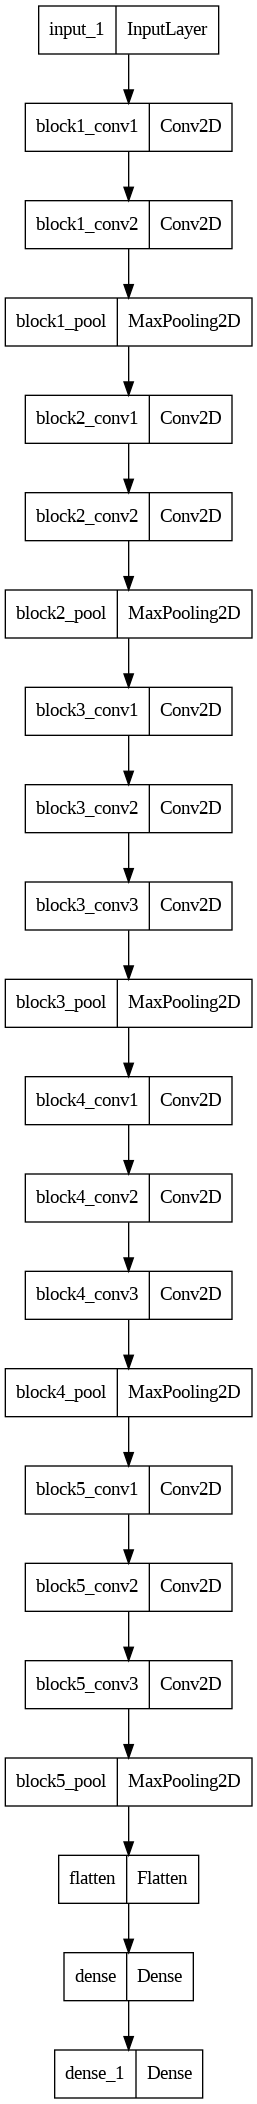

In [ ]:
from keras.utils import plot_model
plot_model(modelv)

In [ ]:

modelv.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:

modelv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='loss',patience=3)
history = modelv.fit(
    train_ds,
    epochs=10,
    callbacks=[callback],
    validation_data=validation_ds
)


Epoch 1/10
75/75 [==============================] - 27s 221ms/step - loss: 0.6861 - accuracy: 0.8037 - val_loss: 0.1828 - val_accuracy: 0.9300
Epoch 2/10
75/75 [==============================] - 12s 153ms/step - loss: 0.1405 - accuracy: 0.9617 - val_loss: 0.1213 - val_accuracy: 0.9567
Epoch 3/10
75/75 [==============================] - 12s 154ms/step - loss: 0.0786 - accuracy: 0.9833 - val_loss: 0.0887 - val_accuracy: 0.9683
Epoch 4/10
75/75 [==============================] - 12s 158ms/step - loss: 0.0491 - accuracy: 0.9942 - val_loss: 0.0599 - val_accuracy: 0.9850
Epoch 5/10
75/75 [==============================] - 12s 161ms/step - loss: 0.0289 - accuracy: 0.9967 - val_loss: 0.0502 - val_accuracy: 0.9883
Epoch 6/10
75/75 [==============================] - 12s 160ms/step - loss: 0.0208 - accuracy: 0.9983 - val_loss: 0.0466 - val_accuracy: 0.9833
Epoch 7/10
75/75 [==============================] - 13s 165ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.0382 - val_accuracy: 0.9917

In [ ]:

modelv.save('tumordetect.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


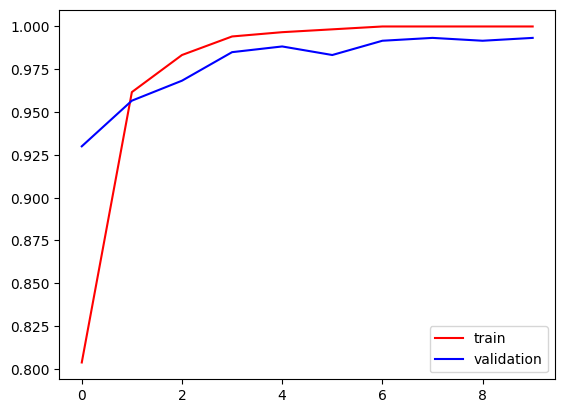

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

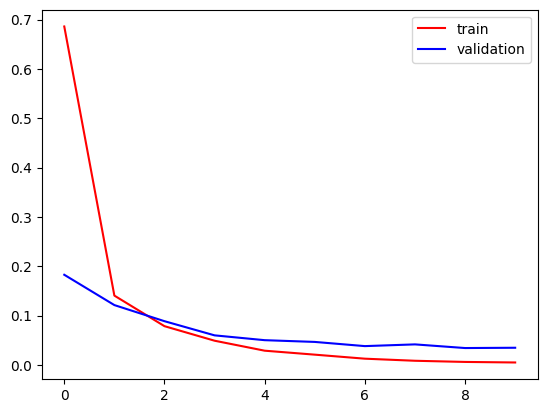

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
conv_base.layers[1].name

'block1_conv1'

In [ ]:
for i in range(len(conv_base.layers)):
  if 'conv' not in conv_base.layers[i].name:
    continue
  filters,biases=conv_base.layers[i].get_weights()
  print('layer number',i,conv_base.layers[i].name,filters.shape)

layer number 1 block1_conv1 (3, 3, 3, 64)
layer number 2 block1_conv2 (3, 3, 64, 64)
layer number 4 block2_conv1 (3, 3, 64, 128)
layer number 5 block2_conv2 (3, 3, 128, 128)
layer number 7 block3_conv1 (3, 3, 128, 256)
layer number 8 block3_conv2 (3, 3, 256, 256)
layer number 9 block3_conv3 (3, 3, 256, 256)
layer number 11 block4_conv1 (3, 3, 256, 512)
layer number 12 block4_conv2 (3, 3, 512, 512)
layer number 13 block4_conv3 (3, 3, 512, 512)
layer number 15 block5_conv1 (3, 3, 512, 512)
layer number 16 block5_conv2 (3, 3, 512, 512)
layer number 17 block5_conv3 (3, 3, 512, 512)


In [ ]:
filters,biases=conv_base.layers[1].get_weights()


In [ ]:
f_min , f_max =filters.min() , filters.max()
filters=(filters - f_min)/(f_max - f_min)

In [ ]:
from matplotlib import pyplot
n_filters=7
ix=1
fig=pyplot.figure(figsize=(15,10))
for i in range(n_filters):
  f=filters[:,:,:,i]
  for j in range(4):
    pyplot.subplot(n_filters,3,ix)
    pyplot.imshow(f[:,:,j],cmap='gray')
    ix+=1
pyplot.show()

NameError: name 'filters' is not defined

<Figure size 1500x1000 with 0 Axes>

In [ ]:
from keras import Model
modelss=Model(inputs=conv_base.inputs,outputs=conv_base.layers[1].output)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
img=load_img('/content/41598_2023_41576_Fig1_HTML (1).jpg',target_size=(224,224))
img=img_to_array(img)
img=np.expand_dims(img,axis=0)
feature=modelss.predict(img)
feature.shape

1/1 [==============================] - 0s 256ms/step


(1, 224, 224, 64)

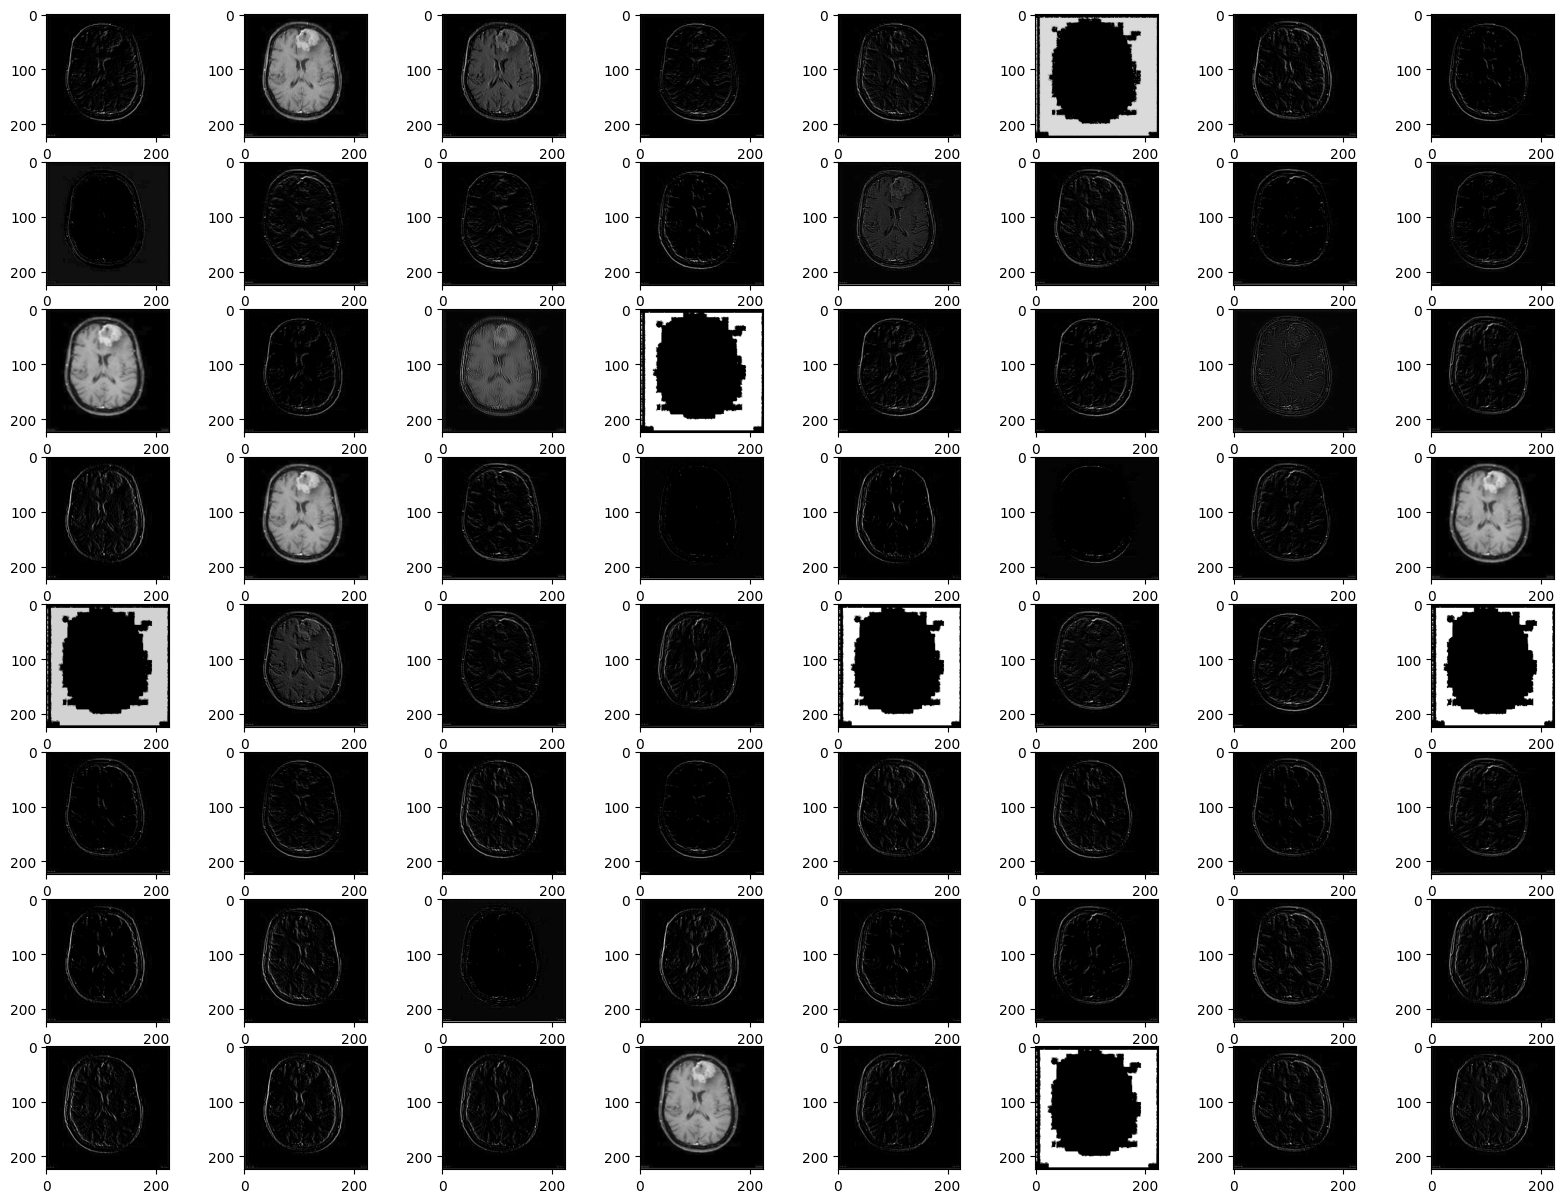

In [ ]:
fig=pyplot.figure(figsize=(20,15))
for i in range(1,feature.shape[3]+1):
  pyplot.subplot(8,8,i)
  pyplot.imshow(feature[0,:,:,i-1],cmap='gray')
pyplot.show()

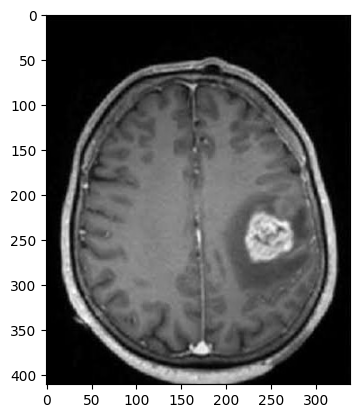

In [ ]:
import cv2
test_img = cv2.imread('/content/WhatsApp Image 2024-07-11 at 16.41.58_76101346.jpg')
plt.imshow(test_img)
test_img.shape
test_img = cv2.resize(test_img,(224,224))

In [ ]:
test_input = test_img.reshape((1,224,224,3))

In [ ]:
predictions=modelv.predict(test_input)
predictions = [1 if x>0.5 else 0 for x in predictions]
predictions

1/1 [==============================] - 1s 1s/step


[1]

1/1 [==============================] - 0s 63ms/step
Classification Report:
               precision    recall  f1-score   support

    No Tumor       1.00      0.99      0.99       295
       Tumor       0.99      1.00      0.99       305

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



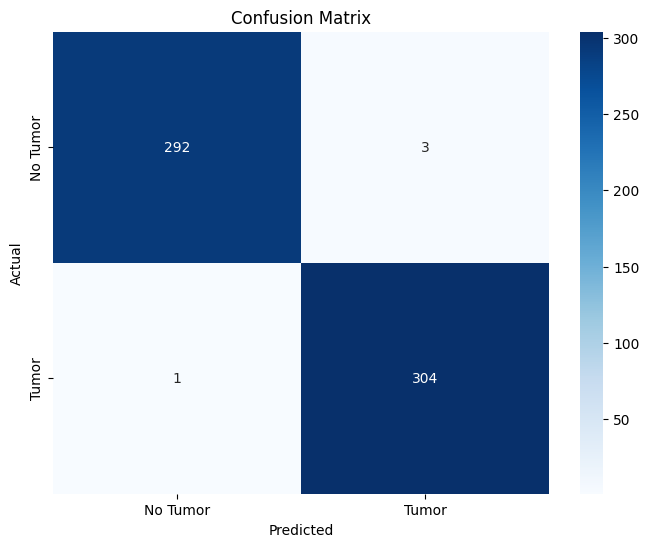

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Assuming 'modelv' is your trained model and 'validation_ds' is your validation dataset

# Collecting true labels and predicted labels
true_labels = []
pred_labels = []

for images, labels in validation_ds:
    true_labels.extend(labels.numpy())
    predictions = modelv.predict(images)
    pred_labels.extend((predictions > 0.5).astype(int).flatten())  # Binary classification threshold at 0.5

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Generate the classification report
report = classification_report(true_labels, pred_labels, target_names=['No Tumor', 'Tumor'])
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from keras import layers, models, applications

In [ ]:
model=Sequential()
model.add(Conv2D(256,kernel_size=(3,3),padding='same',activation='relu',input_shape=(224,224,3)))


model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(256,activation='relu'))

model.add(Dense(64,activation='relu'))

model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history=model.fit(train_ds,validation_data=validation_ds,epochs=10)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.7058 - loss: 9.0769 - val_accuracy: 0.7600 - val_loss: 1.3160
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 65s 570ms/step - accuracy: 0.8426 - loss: 0.9655 - val_accuracy: 0.7383 - val_loss: 1.8609
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 572ms/step - accuracy: 0.9099 - loss: 0.4456 - val_accuracy: 0.8567 - val_loss: 2.2359
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 85s 607ms/step - accuracy: 0.9409 - loss: 0.3093 - val_accuracy: 0.7967 - val_loss: 2.9085
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 79s 573ms/step - accuracy: 0.9545 - loss: 0.3493 - val_accuracy: 0.9450 - val_loss: 0.2218
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 573ms/step - accuracy: 0.9902 - loss: 0.0348 - val_accuracy: 0.9733 - val_loss: 0.1502
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 568ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9800 - val_loss: 0.1415
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 570ms/step - accuracy: 0.9999 - loss: 0.0018 - val_accura

In [ ]:

model.save('braintumor.h5')

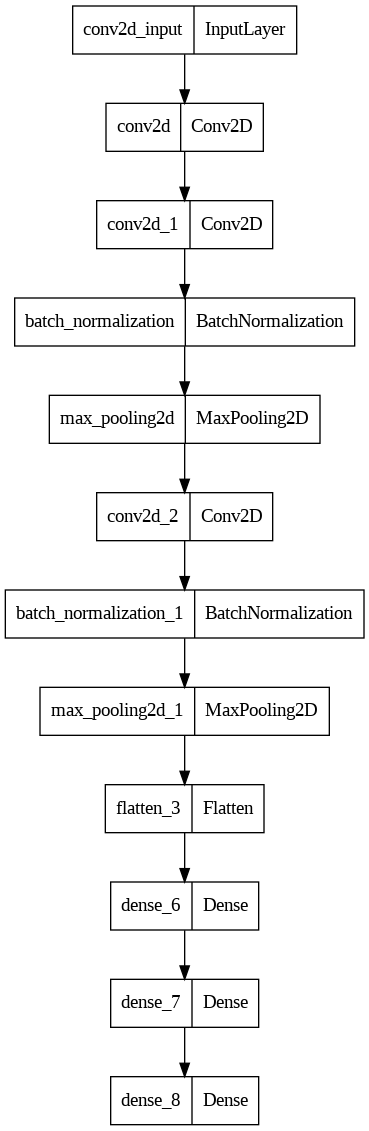

In [ ]:
from keras.utils import plot_model
plot_model(model)

In [ ]:
for i in range(len(model.layers)):
  if 'conv' not in model.layers[i].name:
    continue
  filters,biases=model.layers[i].get_weights()
  print('layer number',i,model.layers[i].name,filters.shape)

layer number 0 conv2d (3, 3, 3, 256)
layer number 1 conv2d_1 (3, 3, 256, 128)
layer number 4 conv2d_2 (3, 3, 128, 64)


In [ ]:
filters ,bias=model.layers[1].get_weights()

In [ ]:
f_min , f_max =filters.min() , filters.max()
filters=(filters - f_min)/(f_max - f_min)

In [ ]:
f_min , f_max =filters.min() , filters.max()
filters=(filters - f_min)/(f_max - f_min)

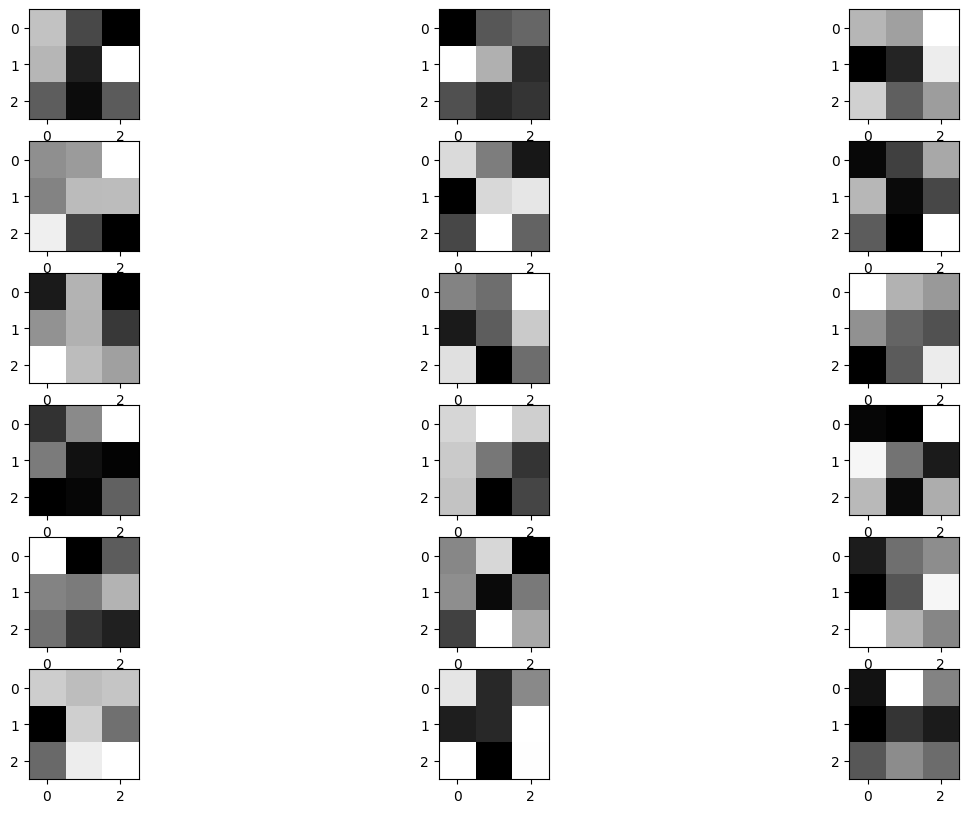

In [ ]:
from matplotlib import pyplot
n_filters=6
ix=1
fig=pyplot.figure(figsize=(15,10))
for i in range(n_filters):
  f=filters[:,:,:,i]
  for j in range(3):
    pyplot.subplot(n_filters,3,ix)
    pyplot.imshow(f[:,:,j],cmap='gray')
    ix+=1
pyplot.show()

In [ ]:
from keras import Model
modelss=Model(inputs=model.inputs,outputs=model.layers[1].output)


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
img=load_img('/content/41598_2023_41576_Fig1_HTML (1).jpg',target_size=(224,224))
img=img_to_array(img)
img=np.expand_dims(img,axis=0)


In [ ]:
feature=modelss.predict(img)

feature.shape

1/1 [==============================] - 1s 544ms/step


(1, 222, 222, 128)

ValueError: num must be an integer with 1 <= num <= 64, not 65

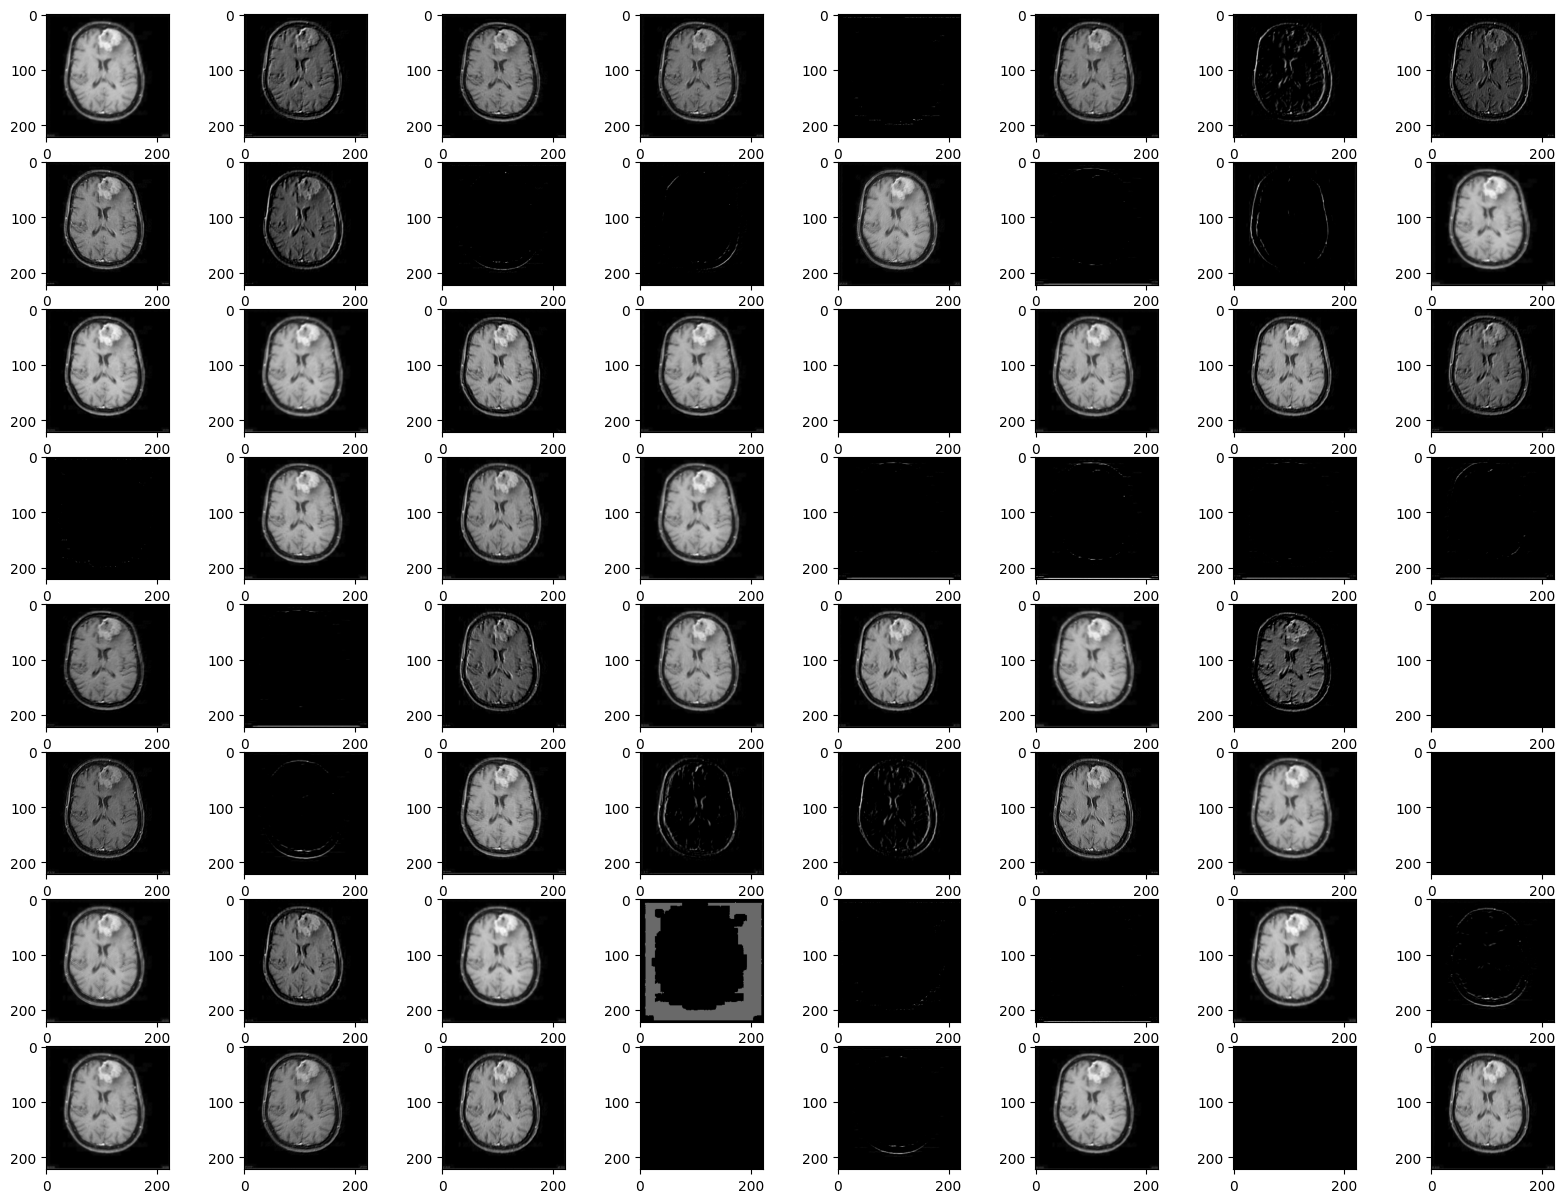

In [ ]:
fig=pyplot.figure(figsize=(20,15))
for i in range(1,feature.shape[3]+1):
  pyplot.subplot(8,8,i)
  pyplot.imshow(feature[0,:,:,i-1],cmap='gray')
pyplot.show()

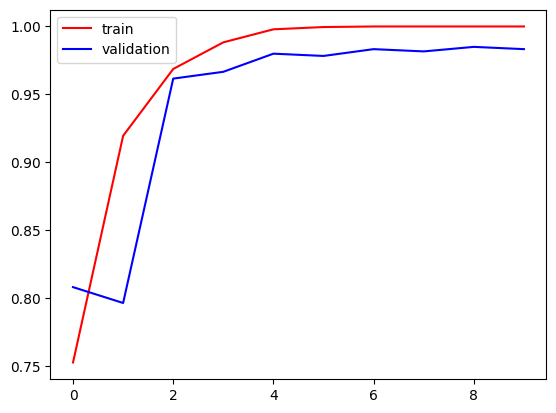

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

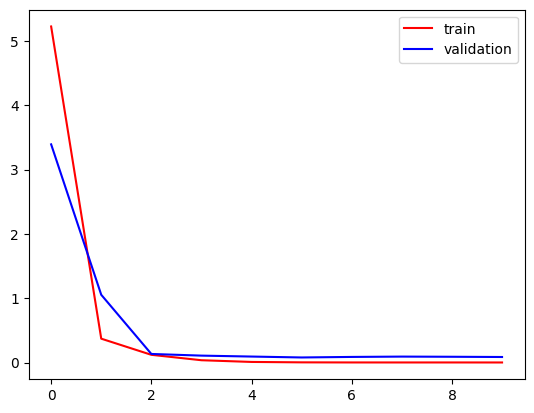

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

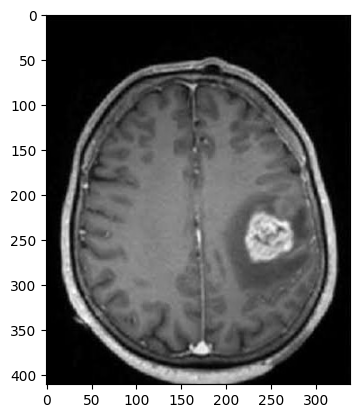

In [ ]:
test_img = cv2.imread('/content/WhatsApp Image 2024-07-11 at 16.41.58_76101346.jpg')
plt.imshow(test_img)
test_img.shape
test_img = cv2.resize(test_img,(224,224))

1/1 [==============================] - 1s 835ms/step


[1]

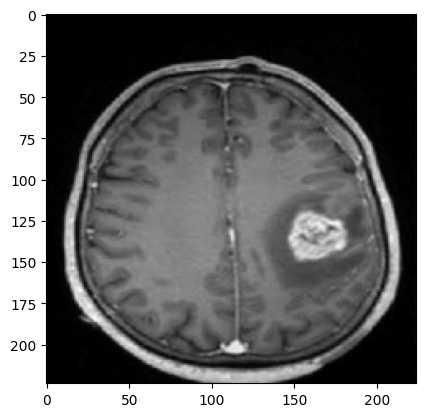

In [ ]:
test_input = test_img.reshape((1,224,224,3))
plt.imshow(test_img)
predictions=model.predict(test_input)
predictions = [1 if x>0.5 else 0 for x in predictions]
predictions